# Measuring Galaxies with Neural Networks

Group 1: Lauren Baker, Kyra Ballard, Kaela Nelson

## Background

Most galaxies can be adequately modeled as a fuzzy blob with some size, shape, and brightness parameters. Understanding these morphology parameters can provide a deeper understanding of the Universe. For example, size and shape of galaxies can tell us about the Universe’s mass distribution and their brightness can tell us about the Universe’s origin and evolution. Standard parametric modeling techniques that have been used previously are limited in their generalizability to all galaxies, motivating the need for using deep convolutional neural networks for more robust estimates of galaxy morphology$^ 1$. 

GalSim is an open-source software for simulating images of galaxies$^ 2$. GalSim can generate mock images as a function of brightness and shape parameters. Specific parameters that are of interest to this project are: 
- flux (brightness)
- Sersic index and radius (shape)
- g1 and g2 (shear, or shape distortion)

Images generated from GalSim can include noise to better represent night sky noise and can include point-spread function smoothing to give galaxies the fuzzy blob effect.


## Project Goals
- Train a CNN on Jun's 18,000+ galaxy images generated using GalSim to estimate 5 morphology parameters: flux, Sersic index, Sersic radius, g1, and g2
- Assess model performance on a test set of simulated images by comparing our model's prediction error of each parameter to the Cramér-Rao bound (CRB) and Jun's CAE prediction error for signal-to-noise (SNR) ratios of 30 and 60.

**References:**

1. Zhu, X. P., et al. (2019). Galaxy morphology classification with deep convolutional neural networks. Astrophysics and Space Science, 364(4). https://doi.org/10.1007/s10509-019-3540-1
1. Rowe, B. T. P., et al. (2015). GalSim: The modular galaxy image simulation toolkit. Astronomy and Computing, 10, 121–150. https://doi.org/10.1016/j.ascom.2015.02.002

## Imports

In [0]:
import matplotlib
import numpy as np
import pandas as pd
import h5py
import math
import pickle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input, UpSampling2D, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Referenced Functions

In [0]:
def get_lr_metric(optimizer): # to print out learning rate during model fitting
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [0]:
def scheduler(epoch): # exponential decay of learning rate
  initial_lrate = 0.0001
  if epoch < 5:
    lrate = initial_lrate
  else:
    lrate = initial_lrate*math.exp(0.1*(5-epoch))
  return lrate

In [0]:
def print_mse(model, model_preds, X_test, y_test, is_unet=False):
  mse_model = model.evaluate(X_test.reshape(-1,64,64,1), y_test, verbose=0)
  if is_unet == True:
    print('Overall UNet test MSE = {}\n'.format(mse_model[0]))
  else:
    print('Overall model test MSE = {}\n'.format(mse_model))
  param_names = ['Flux', 'Sersic index', 'Sersic radius', 'g1', 'g2']

  for i in range(len(param_names)):
    mse = np.mean((y_test[:,i] - model_preds[:,i])**2)
    print('{} MSE = {:f}'.format(param_names[i], mse))

In [0]:
def plot_mse(model_preds, y_test, snr_test):
  param_names = ['Flux', 'Sersic index', 'Sersic radius', 'g1', 'g2']
  fig, ax = plt.subplots(1,len(param_names),figsize=(30,5))
  for i in range(len(param_names)):
        # calc MSE
        mse = np.mean((y_test[:,i] - model_preds[:,i])**2)
        # plot predicted vs. true data, hue = SNR
        data = ax[i].scatter(y_test[:,i], model_preds[:,i], c=snr_test)
        ax[i].set_xlabel('True Value')
        ax[i].set_ylabel('Predicted Value')
        ax[i].set_title('{} MSE = {:.3f}'.format(param_names[i], mse))
        # plot colorbar for SNR
        cbar = fig.colorbar(data, ax=ax[i], orientation='vertical')
        cbar.set_label('SNR', x=5, rotation=-90)
        # plot identity line
        xmin, xmax= ax[i].get_xlim()
        ymin, ymax = ax[i].get_ylim()
        lims = [min([xmin, ymin]), max([xmax, ymax])]
        ax[i].plot(lims, lims, 'orange', linewidth=4, label='MSE=0')
        # set limits to zoom in on data
        ax[i].set_xlim([xmin, xmax])
        ax[i].set_ylim([ymin, ymax]) 
        ax[i].legend(loc='lower right')
  plt.show()

In [0]:
def snr_comparison(snr_test, y_test, preds, snr_val1, snr_val2, plot_im=True):
  # set limits +/- the actual SNR value to have some more data
  upp_lim1 = snr_val1+1
  low_lim1 = snr_val1-1

  upp_lim2 = snr_val2+1
  low_lim2 = snr_val2-1

  print('Mean SNR for data subset 1: {:.5}'.format(np.mean(snr_test[(snr_test > low_lim1) & (snr_test < upp_lim1)])))
  print('Mean SNR for data subset 2: {:.5}'.format(np.mean(snr_test[(snr_test > low_lim2) & (snr_test < upp_lim2)])))

  # Index the true and predicted data based on the SNR values
  y_test_snr1 = y_test[(snr_test > low_lim1) & (snr_test < upp_lim1)]
  preds_snr1 = preds[(snr_test > low_lim1) & (snr_test < upp_lim1)]

  y_test_snr2 = y_test[(snr_test > low_lim2) & (snr_test < upp_lim2)]
  preds_snr2 = preds[(snr_test > low_lim2) & (snr_test < upp_lim2)] 

  # set colors for plotting 
  norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
  snr_val1_color = matplotlib.cm.viridis(norm(snr_val1-5),bytes=True)
  snr_val1_color = tuple([i/255 for i in snr_val1_color])
  snr_val2_color = matplotlib.cm.viridis(norm(snr_val2+5),bytes=True)
  snr_val2_color = tuple([i/255 for i in snr_val2_color])

  # plot
  if plot_im:
    fig, ax = plt.subplots(1, y_test.shape[1], figsize = (30,5))
    for i in range(y_test.shape[1]):
      ax[i].scatter(y_test_snr1[:,i], preds_snr1[:,i], label = 'SNR={}'.format(snr_val1), color=snr_val1_color)
      ax[i].scatter(y_test_snr2[:,i], preds_snr2[:,i], label = 'SNR={}'.format(snr_val2), color=snr_val2_color)
      # plot identity line
      xmin, xmax= ax[i].get_xlim()
      ymin, ymax = ax[i].get_ylim()
      lims = [min([xmin, ymin]), max([xmax, ymax])]
      ax[i].plot(lims, lims, 'orange', linewidth=4, label='MSE=0')
      # set limits to zoom in on data
      ax[i].set_xlim([xmin, xmax])
      ax[i].set_ylim([ymin, ymax]) 
      ax[i].legend(loc='lower right')
      # label
      ax[i].set_title(param_names[i])
      ax[i].set_xlabel('True Value')
      ax[i].set_ylabel('Predicted Value')

    plt.tight_layout()
    plt.show()

  return y_test_snr1, y_test_snr2, preds_snr1, preds_snr2

## Simulation Code

Code used to simulate images to train and test our models.

In [0]:
!apt-get -qq update; apt-get install -y python-dev libfftw3-dev libeigen3-dev ffmpeg pybind11-dev
!pip install galsim

In [0]:
size=200
img_ = np.zeros((size,64,64))
img_nonoise_ = np.zeros((size,64,64))
img_2_ = np.zeros((size,64,64))
gal_flux_ = np.zeros(size)
bulge_re_ =np.zeros(size)
bulge_n_ =np.zeros(size)
gal_q_ = np.zeros(size)
gal_beta_ = np.zeros(size)
psf_ = np.zeros(size)
snr_ = np.zeros(size)
sigma_= np.zeros(size)
g_1_= np.zeros(size)
g_2_= np.zeros(size)

for i in range(size): 

    # fixed parameters 
    image_size = 64        # n x n pixels
    pixel_scale = 0.23     # arcsec / pixel
    random_seed = 1314662
    rng = galsim.BaseDeviate(random_seed+1)
    psf_beta = 2       #moffat parameter 
    
    
    #parameter random generations  
    psf_re= random.uniform(0.5,1)         # PSF moffat scale radius in arcsec 
    bulge_re = random.uniform(0.1,0.6)         # sersic radius, unit arcsec
    bulge_n = random.uniform(0.5,6)        # sersic index 

    # q is ellipticity and beta is orientation. 
    #You could directly predict q and beta but there would be a discontiniuty issue for beta. A jump from 180 degree to 1 degree. 
    # radial sampling for g1 and g2 -reduced shear -> ellipticiy and orientation 
    A= random.uniform(0,0.67)    # gal_q =b/a will ranges in (0.2,1) & A=1-q / 1+q 
    gal_q=(1- A ) /(1+ A ) 
    gal_beta = random.uniform(0,3.14)        #  radians     
    g_1= A *np.cos(2*gal_beta)
    g_2= A *np.sin(2*gal_beta)
    
    noise= random.randint(200,400)
    gal_flux = 1e5*random.uniform(.3,4)
    
    gal = galsim.Sersic(bulge_n, half_light_radius=bulge_re)
    gal = gal.withFlux(gal_flux )
    gal = gal.shear(g1=g_1,g2=g_2)
    psf = galsim.Moffat(beta=psf_beta, flux=1., fwhm=psf_re)   
    final = galsim.Convolve([psf, gal])
    image = galsim.ImageF(image_size, image_size,scale=pixel_scale)
    final.drawImage(image=image);
    image_nonoise = copy.deepcopy(image.array)
    snr=np.sqrt((image.array**2).sum())/noise #signal to noise ratio, after generating data, choose data with snr [10,100]

    image.addNoise(galsim.PoissonNoise(sky_level=0.))   
    noisemap = np.random.normal(0, noise, 64*64)  #noise map for bkgr gaussian noise 
    noisemap=noisemap.reshape((64,64))
    img_fv = image.array+noisemap   #you can also use add noise to add gaussian noise by using 'image.addNoise(galsim.GaussianNoise(sigma=noise)) ' 
    
    final_2 = psf 
    image_2 = galsim.ImageF(image_size, image_size,scale=pixel_scale)
    final_2.drawImage(image=image_2) 

    img_[i]= img_fv # final noised image 
    img_2_[i]= image_2.array  # psf 
    img_nonoise_[i]=image_nonoise  # noiseless image 
    gal_flux_[i] = gal_flux
    bulge_re_[i] =bulge_re
    bulge_n_[i] =bulge_n
    gal_q_[i] =gal_q
    gal_beta_[i] = gal_beta
    psf_[i]=psf_re
    snr_[i]=snr
    sigma_[i]=noise
    g_1_[i]=g_1
    g_2_[i]=g_2

## Load Data

Here we load Jun's 18,000+ simulated images. We will use this data to perform our exploratory data analysis as well as our model training.

In [0]:
filename = 'Data1'
f = h5py.File('/content/drive/My Drive/Colab Notebooks/final_project/models/{}.h5'.format(filename),'r')
image = f['img'][:]    
cat = f['cat'][:]  
label = f['label'][:]   # this gives the set of parameters that characterize the galaxy 
snr = f['snr'][:]
sigma = f['sigma'][:]
image_nonoise = f['img_nonoise'][:]    
image_withnoise = f['img_withnoise'][:]    
f.close()

param_names = ['Flux', 'Sersic index', 'Sersic radius', 'g1', 'g2']

## Exploratory Data Analysis

We first plot a sample of simulated galaxy images to visualize the parameter differences.

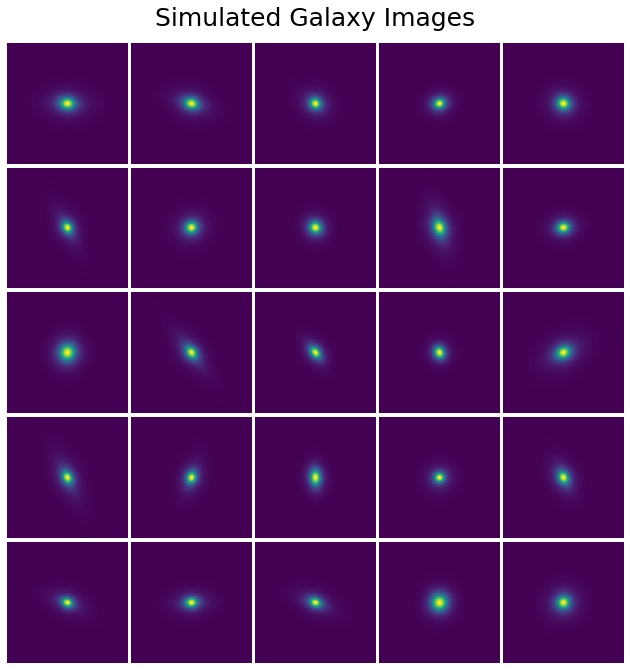

In [11]:
fig, ax = plt.subplots(5,5, figsize = (10,10))
ax = ax.flatten()
for i in range(5):
    ax[5*i].imshow(image_nonoise[20*i])
    ax[5*i].axis('off')

    ax[5*i+1].imshow(image_nonoise[20*i+1])
    ax[5*i+1].axis('off')

    ax[5*i+2].imshow(image_nonoise[20*i+2])
    ax[5*i+2].axis('off')

    ax[5*i+3].imshow(image_nonoise[20*i+3])
    ax[5*i+3].axis('off')

    ax[5*i+4].imshow(image_nonoise[20*i+4])
    ax[5*i+4].axis('off')

plt.suptitle("Simulated Galaxy Images",fontsize=25)
plt.tight_layout(pad=5, h_pad=0.4, w_pad=0.2)
plt.show()

From these subplots, we can see there is some variation in orientation, shape, size, and brightness level. Some images are harder to distinguish from each other (i.e. it is harder to see with the human eye). We now visualize simulated images with their corresponding noisy images. This is important because realistically, galaxy images are noisy.

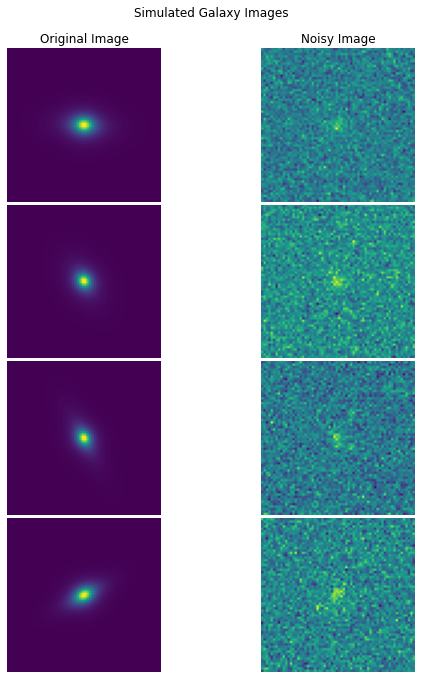

In [12]:
# EDA plots for noisy and corresponding nonnoisy images
fig, ax = plt.subplots(4,2, figsize = (10,10))
ax = ax.flatten()
for i in range(4):
    ax[2*i].imshow(image_nonoise[10*i])
    ax[2*i].axis('off')
    if i == 0:
        ax[3*i].set_title("Original Image")

    ax[2*i+1].imshow(image[10*i])
    ax[2*i+1].axis('off')
    if i == 0:
        ax[2*i+1].set_title("Noisy Image")

plt.suptitle("Simulated Galaxy Images")
plt.tight_layout(pad=4, h_pad=0.3, w_pad=0.3)
plt.show()

In the non-noisy images on the left, it is clear to see differences in shear and brightness. This visual helps us understand that the model we develop will need to capture these differences (as well as other non-visible differences).

## Split data into training and test sets

In [13]:
# split into train and test set
label_df = pd.DataFrame(label)
X_train, X_test, y_train, y_test = train_test_split(image_withnoise, label_df, test_size=0.1)

# get ids of images in training and testing sets
train_ids = y_train.index
test_ids = y_test.index
snr_train = snr[train_ids]
snr_test = snr[test_ids]

# convert y_test and y_train back into arrays
y_train, y_test = y_train.values, y_test.values

print("X_train shape:", X_train.shape, ", y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape, ", y_test shape:", y_test.shape)

X_train shape: (16901, 64, 64) , y_train shape: (16901, 5)
X_test shape: (1878, 64, 64) , y_test shape: (1878, 5)


## Naive CNN Model

We first build a baseline model that can learn parameters of simulated images. The goals for this model are to observe its predicted parameters and learn which parameters are easier, or harder, to learn.


Baseline CNN Architecture:
- 2 conv layers with 16 filters and relu activation 
- max pool layer
- 2 conv layers iwth 32 filters and relu activation 
- max pool layer
- flatten layer
- 1 dense layer with relu activation 
- 1 dense output layer with linear activation 



#### Build Model

In [0]:
model_1 = Sequential()
model_1.add(Conv2D(16,(3,3), padding="same", activation='relu', input_shape=(64,64,1)))
model_1.add(Conv2D(16,(3,3), padding="same", activation='relu'))
model_1.add(MaxPooling2D((2,2), strides=(2,2)))
model_1.add(Conv2D(32,(3,3), padding="same", activation='relu', input_shape=(64,64,1)))
model_1.add(Conv2D(32,(3,3),padding="same", activation='relu'))
model_1.add(MaxPooling2D((2,2), strides=(2,2)))

model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.4))
model_1.add(Dense(5, activation='linear')) 

#### Model Training

In [15]:
# compile
model_1.compile(loss='mean_squared_error', optimizer=Adam(0.001))
# fit
model_1_history = model_1.fit(X_train.reshape(-1,64,64,1), y_train, epochs = 15, validation_split=0.2)

Epoch 1/15
423/423 [==============================] - 3s 8ms/step - loss: 707.7134 - val_loss: 1.1275
Epoch 2/15
423/423 [==============================] - 3s 7ms/step - loss: 1.7516 - val_loss: 0.9734
Epoch 3/15
423/423 [==============================] - 3s 7ms/step - loss: 1.7258 - val_loss: 1.2334
Epoch 4/15
423/423 [==============================] - 3s 7ms/step - loss: 1.6588 - val_loss: 0.8814
Epoch 5/15
423/423 [==============================] - 3s 7ms/step - loss: 1.6187 - val_loss: 1.1237
Epoch 6/15
423/423 [==============================] - 3s 7ms/step - loss: 1.5838 - val_loss: 0.9253
Epoch 7/15
423/423 [==============================] - 3s 7ms/step - loss: 1.4960 - val_loss: 1.0044
Epoch 8/15
423/423 [==============================] - 3s 7ms/step - loss: 1.4669 - val_loss: 1.1557
Epoch 9/15
423/423 [==============================] - 3s 7ms/step - loss: 1.3629 - val_loss: 0.9241
Epoch 10/15
423/423 [==============================] - 3s 7ms/step - loss: 1.2666 - val_loss: 0.97

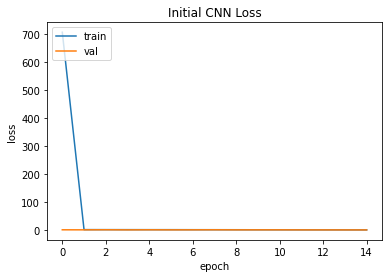

In [16]:
# summarize history for loss
plt.plot(model_1_history.history['loss'])
plt.plot(model_1_history.history['val_loss'])
plt.title('Initial CNN Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Model Predictions

Overall model test MSE = 0.7186326384544373

Flux MSE = 0.774847
Sersic index MSE = 2.646412
Sersic radius MSE = 0.021618
g1 MSE = 0.073653
g2 MSE = 0.076633


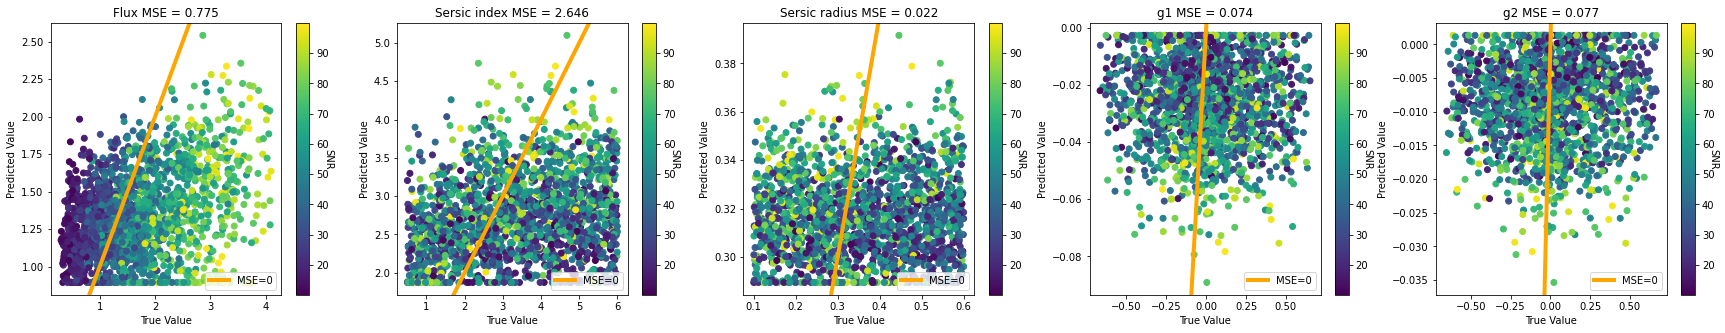

In [17]:
model_1_preds = model_1.predict(X_test.reshape(-1,64,64,1))
print_mse(model_1, model_1_preds, X_test, y_test)
plot_mse(model_1_preds, y_test, snr_test) # model_preds, y_test, snr_test

Please note that this notebook was run after the presentation slides were completed, so the predictions and plots will differ from the slides. This is especially true for this basic CNN model, which was very variable. In some instances of running the notebook, we would find results like this, in which we would find more random scatterplot relationships. In other instances of running this model, we would see the same value was predicted for all parameter values and other times, there were linear relationships starting to exist more strongly like in the subsequent models. Given this wild variability, this model is clearly not able to support the robust parameter prediction that we are interested in and needs to be improved.

For this particular notebook run,  we see that the model may be starting to learn the Flux pattern, but predictions can be improved. The Sersic index and radius and g1 and g2 are hard to predict, as there is large variance.


## U Net Model

Our goal is learn the galaxy parameters well, and produce accruate predictions on newly simulated images. 

The Unet model was initially created for image segmentation problems, where it outputs a complete high resolution image in which all the pixels are classified. We can tailor the unet model to categorizing galaxies, as it learns the parameters (flux, sersic radius, sersic index, g1, and g2), and captures the “where” info, i.e. the shape, orientation, and centering of the galaxies. In our unet model, we flatten the layer convolutional layer and add two dense layers because we want our model to output the five learned galaxy parameters.

We also included the following to improve our model performance:
- Dropout layers in between the two dense layers to reduce problem size and overfitting
- l2 regularization to the dense layers to reduce problem size
- Batch normalization layers: increases the stability by normalizing the output of its previous activation layer (subtracts the batch mean and divides by the batch standard deviation)
- Learning rate scheduler: adjust learning rate during training in order to optimize performance

More info on batch normalization: https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821

Original UNet paper for reference: https://arxiv.org/pdf/1505.04597.pdf


#### Build Model

In [18]:
# Encoder
input_feat = Input(shape=(64,64,1))
conv_layer1 = Conv2D(64,(3,3), padding="same", activation='relu')(input_feat)
batch_normed1 = tf.keras.layers.BatchNormalization()(conv_layer1)
conv_layer2 = Conv2D(64,(3,3), padding="same", activation='relu')(batch_normed1)
max_pool1 = MaxPooling2D((2,2), strides=(2,2))(conv_layer2)

conv_layer3 = Conv2D(128,(3,3), padding="same", activation='relu')(max_pool1)
batch_normed2 = tf.keras.layers.BatchNormalization()(conv_layer3)
conv_layer4 = Conv2D(128,(3,3), padding="same", activation='relu')(batch_normed2)
max_pool2 = MaxPooling2D((2,2), strides=(2,2))(conv_layer4)

conv_layer5 = Conv2D(256,(3,3), padding="same", activation='relu')(max_pool2)
batch_normed3 = tf.keras.layers.BatchNormalization()(conv_layer5)
conv_layer6 = Conv2D(256,(3,3),padding="same", activation='relu')(batch_normed3)
max_pool3 = MaxPooling2D((2,2), strides=(2,2))(conv_layer6)

conv_layer7 = Conv2D(512,(3,3), padding="same", activation='relu')(max_pool3)
batch_normed4 = tf.keras.layers.BatchNormalization()(conv_layer7)
conv_layer8 = Conv2D(512,(3,3),padding="same", activation='relu')(batch_normed4)
max_pool4 = MaxPooling2D((2,2), strides=(2,2))(conv_layer8)

# bottleneck
conv_layer9 = Conv2D(1024,(3,3), padding="same", activation='relu')(max_pool4)
batch_normed5 = tf.keras.layers.BatchNormalization()(conv_layer9)
conv_layer10 = Conv2D(1024,(3,3),padding="same", activation='relu')(batch_normed5)

# Decoder
# upsampling and concatenating with feature map from same level in encoder
upsample1 = UpSampling2D((2,2))(conv_layer9)
concat1 = Concatenate()([upsample1, conv_layer8])
conv_layer11 = Conv2D(256,(3,3), padding="same", activation='relu')(concat1)
conv_layer12 = Conv2D(256,(3,3),padding="same", activation='relu')(conv_layer11)

upsample2 = UpSampling2D((2,2))(conv_layer11)
concat2 = Concatenate()([upsample2, conv_layer6])
conv_layer13 = Conv2D(128,(3,3), padding="same", activation='relu')(concat2)
conv_layer14 = Conv2D(128,(3,3),padding="same", activation='relu')(conv_layer13)

upsample3 = UpSampling2D((2,2))(conv_layer13)
concat3 = Concatenate()([upsample3, conv_layer4])
conv_layer15 = Conv2D(64,(3,3), padding="same", activation='relu')(concat3)
conv_layer16 = Conv2D(64,(3,3),padding="same", activation='relu')(conv_layer15)

upsample4 = UpSampling2D((2,2))(conv_layer15)
concat4 = Concatenate()([upsample4, conv_layer2])
conv_layer17 = Conv2D(64,(3,3), padding="same", activation='relu')(concat4)
conv_layer18 = Conv2D(64,(3,3),padding="same", activation='relu')(conv_layer17)

flat1 = Flatten()(conv_layer18)
dense1 = Dense(64, activation='linear')(flat1)
drop1 = Dropout(0.5)(dense1)
output = Dense(5, activation='linear')(drop1)

unet_model = tf.keras.Model(input_feat, output)
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 64, 64, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 64)   256         conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 64, 64)   36928       batch_normalization[0][0]        
______________________________________________________________________________________________

#### Compile model

In [0]:
optimizer = Adam()
lr_metric = get_lr_metric(optimizer)
unet_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy', lr_metric])

#### Fit model on noisy data

We implemented a learning rate scheduler that exponentially decays the learning rate as epoch increases.

In [20]:
# Define learning rate scheduler
lrate = LearningRateScheduler(scheduler)
callbacks_list = [lrate]

# Fit
unet_model_history = unet_model.fit(X_train.reshape(-1,64,64,1), y_train, epochs=20, validation_split=0.2, callbacks=callbacks_list, verbose=1)

Epoch 1/20
423/423 [==============================] - 42s 98ms/step - loss: 2.9015 - accuracy: 0.7889 - lr: 1.0000e-04 - val_loss: 0.4296 - val_accuracy: 0.8373 - val_lr: 1.0000e-04
Epoch 2/20
423/423 [==============================] - 39s 93ms/step - loss: 0.6165 - accuracy: 0.8549 - lr: 1.0000e-04 - val_loss: 0.3579 - val_accuracy: 0.8634 - val_lr: 1.0000e-04
Epoch 3/20
423/423 [==============================] - 39s 92ms/step - loss: 0.5288 - accuracy: 0.8770 - lr: 1.0000e-04 - val_loss: 0.4353 - val_accuracy: 0.8489 - val_lr: 1.0000e-04
Epoch 4/20
423/423 [==============================] - 39s 92ms/step - loss: 0.4596 - accuracy: 0.8879 - lr: 1.0000e-04 - val_loss: 0.3542 - val_accuracy: 0.8687 - val_lr: 1.0000e-04
Epoch 5/20
423/423 [==============================] - 39s 92ms/step - loss: 0.4073 - accuracy: 0.9035 - lr: 1.0000e-04 - val_loss: 0.3617 - val_accuracy: 0.8719 - val_lr: 1.0000e-04
Epoch 6/20
423/423 [==============================] - 39s 92ms/step - loss: 0.3655 - accur

### Plot Unet Model Loss

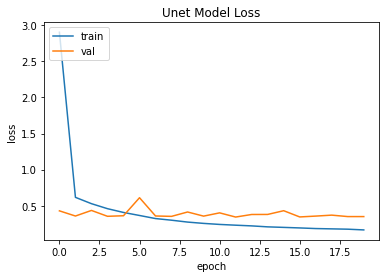

In [21]:
# summarize history for loss
plt.plot(unet_model_history.history['loss'])
plt.plot(unet_model_history.history['val_loss'])
plt.title('Unet Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
# unet_model.save_weights("/content/drive/My Drive/Colab Notebooks/final_project/models/saved_models/{}.h5".format('unet_model_weights_final'))

### Predict on test

In [0]:
preds = unet_model.predict(X_test.reshape(-1,64,64,1))

### Plot predicted vs. true values for all parameters

Overall UNet test MSE = 0.3520337641239166

Flux MSE = 0.060633
Sersic index MSE = 1.635603
Sersic radius MSE = 0.017382
g1 MSE = 0.022763
g2 MSE = 0.023786


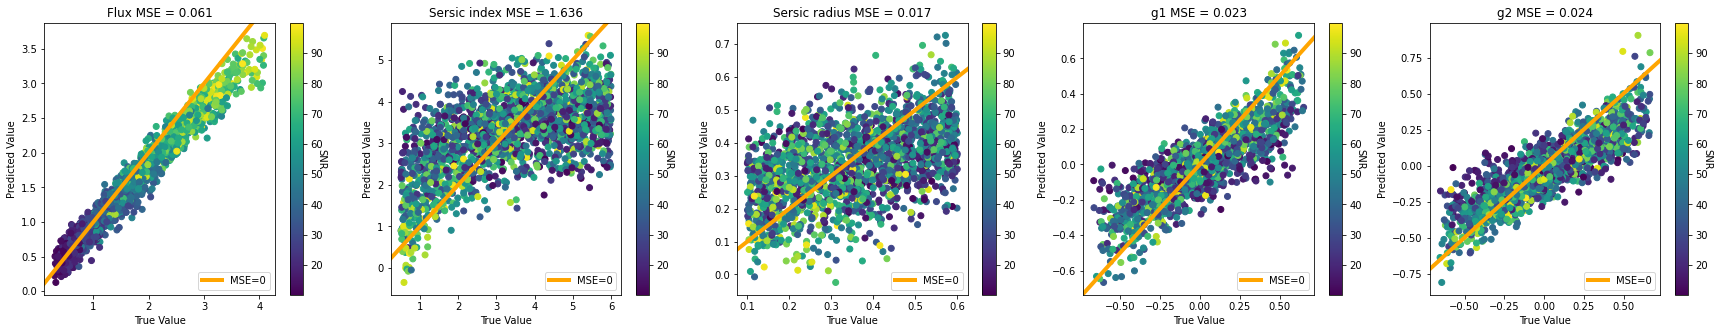

In [24]:
print_mse(unet_model, preds,X_test, y_test, is_unet=True)
plot_mse(preds, y_test, snr_test) # model_preds, y_test, snr_test

We observe from the plots above that the flux predictions are very good (low mse and low variance around the mse=0 line). The Sersic index and radius both have more variation, however, it looks like the model is learning their pattern decently well given we knew these parameters were the hardest to learn. Lastly the g1 and g2 predicted values are also decent, as they are surrounding the zero error line, yet not as low variance as flux. Although there is definitely prediction error present in all parameters, we would conclude this model was able to predict these parameters reasonably well on this noisy test data set. The architecture of the unet model enabled much more consistent predictions than the basic CNN model, as we saw data relationships very similar to this upon repeated runs of the notebook. We feel that this model is therefore reasonably robust.

### Breakdown by SNR

We also visualized the simulated galaxy images with SNR=30 and SNR=60. To obtain this data set, we subsetted the data for images with snr between 29-31 for SNR=30, and between 59-61 for SNR=60. We chose those bounds to have more data to visualize, as opposed to only looking at data strictly at SNR=30 or 60. We plot these subsets below.

Mean SNR for data subset 1: 30.068
Mean SNR for data subset 2: 59.939


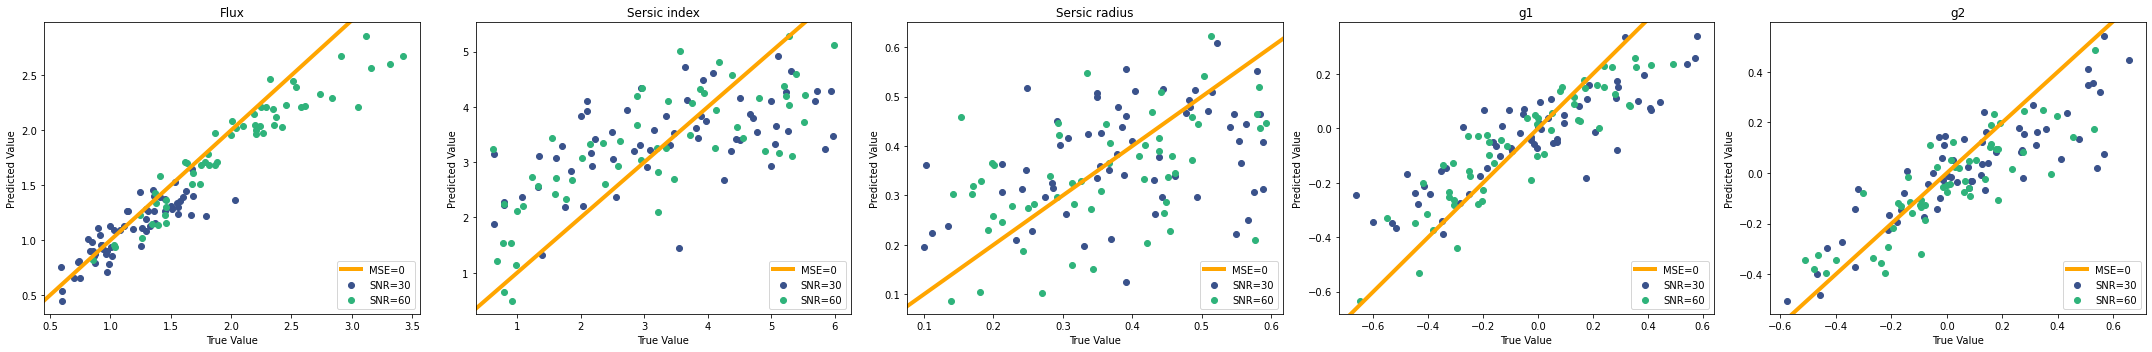

In [25]:
y_test_snr30, y_test_snr60, preds_snr30, preds_snr60 = snr_comparison(snr_test, y_test, preds, 30, 60)

In [0]:
pred_error_snr30 = [y_test_snr30[:,i] - preds_snr30[:,i] for i in range(y_test_snr30.shape[1])]
pred_error_snr60 = [y_test_snr60[:,i] - preds_snr60[:,i] for i in range(y_test_snr60.shape[1])]

We can see from the plots above that the images with SNR close to 30 and 60 have rather accurate predictions, as they remain close to the mse=0 line. Notice that the flux values are lower for SNR=30, and higher for SNR=60 galaxies - we can see a nice clustering in this plot. The other parameters do not have this same clustering pattern. Sersic index and sersic radius have more variation, which is expected due to our initial observations.

#### SNR=30

In [27]:
print('SNR = 30:')
for i in range(len(param_names)):
    print(param_names[i], ' mean: {:.3}, +/- std: {:.3}'.format(pred_error_snr30[i].mean(), pred_error_snr30[i].std()))

SNR = 30:
Flux  mean: 0.0788, +/- std: 0.174
Sersic index  mean: -0.0292, +/- std: 1.23
Sersic radius  mean: 0.0133, +/- std: 0.134
g1  mean: 0.00613, +/- std: 0.18
g2  mean: 0.0636, +/- std: 0.152


Parameters | Value | CRB | Jun's CAE | Our UNet
--- | --- | --- | --- | --- 
 Flux $(10^5)$| 1 | 0.11 | -0.052 $\pm$ 0.12 | 0.0788 $\pm$ 0.174
Sersic Index | 3 | 1.56 | -0.57 $\pm$ 0.85 | -0.0292 $\pm$ 1.23
Sersic Radius | 0.3 | 0.056 | 0.001 $\pm$ 0.06 | 0.0133 $\pm$  0.134
g1 | -0.069 | 0.11 | -0.019 $\pm$ 0.10 | 0.00613 $\pm$ 0.18
g2 | 0.15 | 0.11 | 0.046 $\pm$ 0.10 | 0.0636 $\pm$ std: 0.152


We evaluate our model's performance by comparing our predictions' mean error for the subset of galaxy images with SNR=30 to that of the Cramer-Rao bound (CRB) and Jun's convolutional autoencoder model (CAE). We can see that our model has relatively low mean error and performs well, as they are relatively close in value to the Jun's and CRB. The Sersic index has the highest standard deviation which would follow the variability we saw in the plot. 

#### SNR=60

In [28]:
print('SNR = 60:')
for i in range(len(param_names)):
    print(param_names[i], ' mean: {:.3}, +/- std: {:.3}'.format(pred_error_snr60[i].mean(), pred_error_snr60[i].std()))

SNR = 60:
Flux  mean: 0.181, +/- std: 0.209
Sersic index  mean: -0.145, +/- std: 1.04
Sersic radius  mean: 0.0135, +/- std: 0.125
g1  mean: 0.00219, +/- std: 0.123
g2  mean: 0.0525, +/- std: 0.125


Parameters | Value | CRB | Jun's CAE | Our UNet
--- | --- | --- | --- | --- 
 Flux$(10^5)$ | 1 | 0.056 | -0.016 $\pm$ 0.072 | 0.181 $\pm$ 0.209
Sersic Index | 3 | 0.78 | -0.48 $\pm$ 0.67 | -0.145 $\pm$ 1.04
Sersic Radius | 0.3 | 0.028 | -0.012 $\pm$ 0.036 | 0.0135 $\pm$ 0.125
g1 | -0.069 | 0.054 | 0.001 $\pm$ 0.0532 | 0.00219  $\pm$ 0.123
g2 | 0.15 | 0.054 | -0.027 $\pm$ 0.061 | 0.0525 $\pm$ 0.125


We perform the same analysis with SNR=60. We can see that our model has relatively low mean error and performs well, as they are relatively close in value to the CRB. The Sersic index has the highest standard deviation which would follow the variability we saw in the plot.

## Predicting on data without noise

We now use our model, trained on the noisy data, and predict on the galaxy simulated images without noise and evaluate performance. We expect the predictions to be very accurate, as the parameters of images without noise should be easier to predict that those with noise (less variaton to account for).

In [0]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(image_nonoise, label_df, test_size=0.1)

# get ids of images in training and testing sets
train_ids2 = y_train2.index
test_ids2 = y_test2.index
snr_train2 = snr[train_ids2]
snr_test2 = snr[test_ids2]

# convert y_test and y_train back into arrays
y_train2, y_test2 = y_train2.values, y_test2.values

Overall UNet test MSE = 0.30036601424217224

Flux MSE = 0.044212
Sersic index MSE = 1.404123
Sersic radius MSE = 0.010347
g1 MSE = 0.023214
g2 MSE = 0.019934


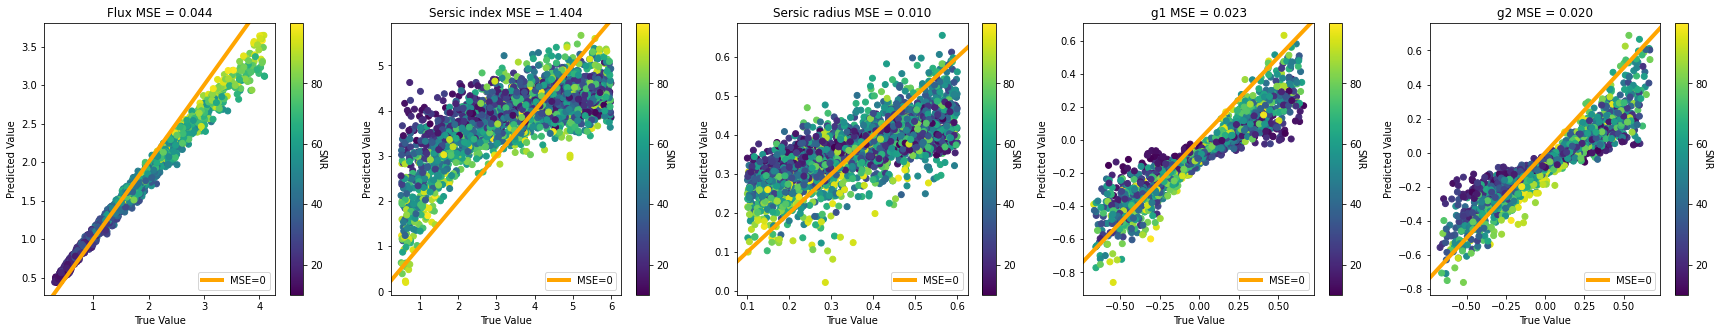

In [30]:
preds_nonoisy = unet_model.predict(X_test2.reshape(-1,64,64,1))
print_mse(unet_model, preds_nonoisy, X_test2, y_test2, is_unet=True)
plot_mse(preds_nonoisy, y_test2, snr_test2)

As predicted, the MSE scores for the predictions with non-noisy data are slightly lower than the predictions with the noisy test set. These values are quite similar per parameter , however, which makes us confident in the robustness of our model for handling noisy images. Even with the non-noisy data the Sersic index still showed the most variability.

### SNR plots for "clean" galaxies (non-noisy images)

Mean SNR for data subset 1: 29.863
Mean SNR for data subset 2: 59.907


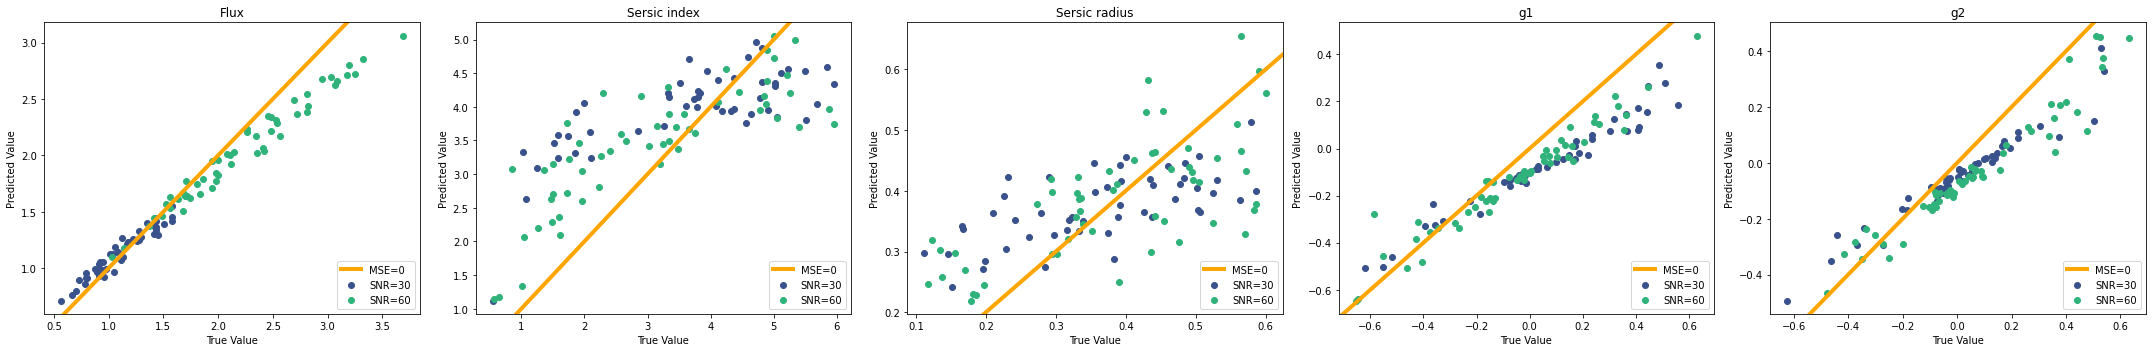

In [31]:
y_test2_snr30, y_test2_snr60, preds_nonoisy_snr30, preds_nonoisy_snr60 = snr_comparison(snr_test2, y_test2, preds_nonoisy, 30, 60)

In [0]:
pred_error2_snr30 = [y_test2_snr30[:,i] - preds_nonoisy_snr30[:,i] for i in range(y_test2_snr30.shape[1])]
pred_error2_snr60 = [y_test2_snr60[:,i] - preds_nonoisy_snr60[:,i] for i in range(y_test2_snr60.shape[1])]

#### SNR=30 for "clean" galaxies

In [33]:
print('SNR = 30')
for i in range(len(param_names)):
    print(param_names[i], ' mean: {:.3}, +/- std: {:.3}'.format(pred_error2_snr30[i].mean(), pred_error2_snr30[i].std()))

SNR = 30
Flux  mean: -0.0265, +/- std: 0.0843
Sersic index  mean: -0.291, +/- std: 1.07
Sersic radius  mean: -0.0117, +/- std: 0.0974
g1  mean: 0.125, +/- std: 0.11
g2  mean: 0.0566, +/- std: 0.0927


Parameters | Value | CRB | Jun's CAE | Our UNet | UNet predicted on non-noisy data
--- | --- | --- | --- | --- | --
 Flux $(10^5)$| 1 | 0.11 | -0.052 $\pm$ 0.12 | 0.0788 $\pm$ 0.174 |-0.0265  $\pm$ 0.0843
Sersic Index | 3 | 1.56 | -0.57 $\pm$ 0.85 | -0.0292 $\pm$ 1.23 | -0.291 $\pm$ 1.07
Sersic Radius | 0.3 | 0.056 | 0.001 $\pm$ 0.06 | 0.0133 $\pm$  0.134 | -0.0117 $\pm$ 0.0974
g1 | -0.069 | 0.11 | -0.019 $\pm$ 0.10 | 0.00613 $\pm$ 0.18 | 0.125 $\pm$  0.11
g2 | 0.15 | 0.11 | 0.046 $\pm$ 0.10 | 0.0636 $\pm$ std: 0.152 | 0.0566 $\pm$ 0.0927

#### SNR=60 for "clean" galaxies

In [34]:
print('SNR = 60')
for i in range(len(param_names)):
    print(param_names[i], ' mean: {:.3}, +/- std: {:.3}'.format(pred_error2_snr60[i].mean(), pred_error2_snr60[i].std()))

SNR = 60
Flux  mean: 0.185, +/- std: 0.173
Sersic index  mean: -0.356, +/- std: 0.954
Sersic radius  mean: -0.0017, +/- std: 0.102
g1  mean: 0.0744, +/- std: 0.0903
g2  mean: 0.0973, +/- std: 0.0869


Parameters | Value | CRB | Jun's CAE | Our UNet | UNet predicted on non-noisy data
--- | --- | --- | --- | --- | ---
 Flux$(10^5)$ | 1 | 0.056 | -0.016 $\pm$ 0.072 | 0.181 $\pm$ 0.209 | 0.185 $\pm$ 0.173
Sersic Index | 3 | 0.78 | -0.48 $\pm$ 0.67 | -0.145 $\pm$ 1.04 | -0.356 $\pm$ 0.954
Sersic Radius | 0.3 | 0.028 | -0.012 $\pm$ 0.036 | 0.0135 $\pm$ 0.125 | -0.0017 $\pm$ 0.102
g1 | -0.069 | 0.054 | 0.001 $\pm$ 0.0532 | 0.00219  $\pm$ 0.123 | 0.0744 $\pm$ 0.0903
g2 | 0.15 | 0.054 | -0.027 $\pm$ 0.061 | 0.0525 $\pm$ 0.125 | 0.0973 $\pm$ 0.0869

Observations:

Predicting on the non-noisy data yielded similar results as predicting on the noisy test set for both SNR=30 and SNR=60, with overal low prediction error and similarity to CRB and Jun's. The Sersic index continues to have high standard deviation and will need to do additional model tuning to better understand this parameter.



## Predicting on 200 Simulated Images

We simulated 200 images using the simulation code provided at the beginning of the notebook. We hold all parameters constant (see values below) and vary the noise. The parameters that are held constant are as follows:

- Psf = 0.5        
- Flux = 1e5*1 
- Sersic radius = 0.3   
- Sersic index = 3 
- g1 = -0.069 
- g2 = 0.15 
- Noise = random.randint(200,400)


In [0]:
def open_simulations(path):
  pkl_file = open(path,'rb')
  data1 = pickle.load(pkl_file)
  pkl_file.close()

  data = [data1[i] for i in data1.keys()]
  return data

path='/content/drive/My Drive/Colab Notebooks/final_project/simulations/simulated_data/sim_200_lauren.pkl'
img, img_nonoise, label, snr, sigma = open_simulations(path)

In [36]:
img.shape, img_nonoise.shape, label.shape, snr.shape, sigma.shape

((200, 64, 64), (200, 64, 64), (200, 5), (200,), (200,))

In [0]:
param_names = ['Flux', 'Sersic index', 'Sersic radius', 'g1', 'g2']
label_df = pd.DataFrame(label)
X_train_sim, X_test_sim, y_train_sim, y_test_sim = train_test_split(img, label_df, test_size=0.1)

# get ids of images in training and testing sets
train_ids_sim = y_train_sim.index
test_ids_sim = y_test_sim.index
snr_train_sim = snr[train_ids_sim]
snr_test_sim = snr[test_ids_sim]

# convert y_test and y_train back into arrays
y_train_sim, y_test_sim = y_train_sim.values, y_test_sim.values

In [0]:
# unet_model.load_weights("/content/drive/My Drive/Colab Notebooks/final_project/models/saved_models/unet_model_weights_final.h5")

In [39]:
# predict
preds_sim = unet_model.predict(X_test_sim.reshape(-1,64,64,1))

print("Average Predicted Parameter Values:", np.mean(preds_sim, axis=0))
print("Std of Predicted Parameter Values:", np.std(preds_sim, axis=0))

Average Predicted Parameter Values: [ 0.9329785   3.4613376   0.2209096  -0.03131121  0.07358889]
Std of Predicted Parameter Values: [0.09517202 0.49131677 0.09373225 0.07223485 0.08655676]


| Parameter   | True Values           | Avg Predicted Values |
|-------------|-----------------------|----------------------|
|Flux ($10^5$)|1                      | 0.93 $\pm$ 0.0952   |
|Sersic index |3                      | 3.46  $\pm$ 0.0491   |
|Sersic radius|0.3                    | 0.22  $\pm$  0.0937  |
|g1           |-0.069                 | -0.031  $\pm$ 0.0722  |
|g2           |0.15                   | 0.073  $\pm$  0.0866  |
|Psf          |0.5                    | N/A                  | 
|Noise        |random.randint(200,400)| N/A                  |

We see that the unet model predicted values that were very close to the true values. This is quite impressive, given that the model has not "seen" these simulated images before. Note the very small standard deviations across parameters, indicating that predictions were not as consistent. Because we fixed these 5 parameters, this was a simple case of the model performing well. To extend further past this project, we would simulate more galaxy images, varying more parameters in order to test the robustness of our model.

## Final Thoughts & Future Work

In this project, we were able to create a model that accomplished our goal to learn the parameters of the simulated galaxy images and accurately predict, given a sample of mock galaxy images. The architecture of the unet model was able to learn the parameters of the simulateed images well, with four out of the five paramaters (flux, Sersic radius, g1, and g2) showing minimal prediction error. The Sersic index was consistently more difficult to predict, and represents an area for model improvement. 

For future work and possible extensions to this project, we feel that it would be interesting to continue testing the robustness of our unet model. This would involve simualting more images with varying parameters, or increasing noise, and adjusting our model as needed. It would be interesting to be able to test the limits of our model.

Overall, we very much enjoyed learning about galaxies in this project module. We felt that this was a very interesting problem to investigate, and this project was a nice hands-on way to explore a variety of neural network tuning methods. 

